### Analyzing Cog Sci abstract data
March 4, 2018

This notebook grabs the cogsci proceedings data and does the following.

###### LSA:
- pre-processing: creates tf-idf representation of each abstract.
- analysis: performs Latent Semantic Analysis (truncated SVD) using gensim for latent space document and term representation.
- clustering: hierarchical clustering, t-SNE, PCA?

###### word2vec:
DONE: gensim automatically takes care of preprocessing here, which is super nice
- skip-gram/cbow pre-processing
- build word2vec model using gensim for word meaning vectors



LATER: build doc2vec model using gensim for doc meaning

All analyses are first done with only cognitive key words for a sparse but cognition-specific model, then it's repeated with all words for a fuller dataset.

In [133]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import gensim as gs
from sklearn import decomposition, metrics, cluster

import string, sys, nltk, os
sys.path.append('../')
import cogont as co

# nltk.download() # get the popular package
print(next(p for p in nltk.data.path if os.path.exists(p)))
from nltk.corpus import stopwords

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/rdgao/nltk_data


### function defs

In [48]:
def terms_similar_to(term_sim, dictionary, query_term='attention', topN=10):
    # querying top N similar words
    if query_term in dictionary.token2id.keys():
        query_ind = dictionary.token2id[query_term]
        print('Freq. | Similarity: Term')
        print('------------------------')
        for i in np.argsort(term_sim[query_ind,:])[::-1][:topN]:
            print('%.3f | %.3f: '%(dictionary.dfs[i]/dictionary.num_docs, term_sim[query_ind,i]) + dictionary.id2token[i])

    else:
        print(query_term + ' is not in the dictionary.')



def wv_similar_to(word_vec, all_vectors, topN=10):
    # find the top N most similar words in terms of cosine similarity
    cos_sim = metrics.pairwise.cosine_similarity(word_vec.astype('float64').reshape(1,-1),
                                                 all_vectors.astype('float64')).squeeze()
    top_inds = np.argsort(cos_sim)[::-1][:topN]
    return top_inds, cos_sim[top_inds]


def most_similar_subset(all_vocab, subset_vocab, all_vectors, positive, negative=[], topn=10):
    # similar to gensim.KeyedVectors.similar_to(), but with a restricted dictionary to search from
    # and can also with any word vectors, like LSA representation
    # so this will do the exact same thing as terms_similar_to() above when given the same dictionary

    # this takes long for repeatedly querying big dicts, so have an option for precomputed indices
    if type(subset_vocab[0]) is str:
        # compute only if subset is given in strings
        subset_inds = np.sort([all_vocab.index(t) for t in subset_vocab if t in all_vocab])
    else:
        # otherwise, assume it's precomputed indices
        print('Using precomputed subset indices...')
        subset_inds = subset_vocab

    query_vec = np.zeros_like(all_vectors[0,:])
    pos_neg = [positive, negative]
    weight=[1,-1]
    for i in range(len(pos_neg)):
        for t in pos_neg[i]:
            if t in all_vocab:
                query_vec = query_vec + weight[i]*all_vectors[all_vocab.index(t),:]
            else:
                print(t+' is not in vocabulary. Discarded.')

    topN_inds, topN_sim = wv_similar_to(query_vec, all_vectors[subset_inds,:], topN=topn)
    return [([all_vocab[i] for i in subset_inds][w], topN_sim[i]) for i,w in enumerate(topN_inds)]

def print_similarity(similarity_list):
    # just a helper function to pretty print the similarity list
    print('----------------\nCosine Similiarty\n---------------')
    for w in similarity_list:
        print('%.4f: '%w[1] + w[0])
        
        
def terms_to_phrases(sentence_list_orig, terms_orig, merge_char=' '):
    # takes a sentence list (prepped for word2vec) and find multi-word phrases from
    # a dictionary (terms_orig) and merge them into single terms
    sentence_list = [s for s in sentence_list_orig]
    terms = [t for t in terms_orig]
    
    # takes multi-word terms and merge them into phrases, and change the sentence_list accordingly
    for t_ind, t in enumerate(terms):
        t_split = t.split(sep=' ')
        # if it's a multi-word term
        if len(t_split)>1:
            terms[t_ind] = merge_char.join(t_split)
            print(terms[t_ind])
            for s in sentence_list:
                # go through all the sentences to find and combine that phrase
                for i,w in enumerate(s):
                    if w == t_split[0] and s[i:i+len(t_split)]==t_split:
                        s[i:i+len(t_split)] = [merge_char.join(t_split)]

    return sentence_list, terms

# importing and prepping data into various formats

In [108]:
use_all_words = True

# import dictionary (cognitive concept word list)
terms_file = '../data/cogatlas_terms.txt'
terms = pd.read_csv(terms_file, delimiter='\n', names=['Terms'])

# import data as pd dataframe
cs_abstract_file = '../data/abstracts_cogsci_combined.csv'
df_cs = pd.read_csv(cs_abstract_file, header=0, index_col=False, usecols=['Year', 'Title', 'Abstract'])
print('%i documents extracted.' %len(df_cs))

# making a corpus (document list) and term:index dictionary
doc_list = co.df_to_doclist(df_cs)
if use_all_words:
    # this will produce a lot of garbage words that I'm not sure what to do with
    stop_words = stopwords.words('english')
    all_words = np.unique([w for w in nltk.word_tokenize(docs_joined) if (w not in stop_words and w.isalpha())])
    all_terms = np.unique(list(terms['Terms'])+list(all_words)) # append all the compound terms like working memory
else:
    all_terms = terms['Terms'].values
    
_, docs_as_terms, _ = co.corpus_from_list(doc_list, all_terms)
print('Done.')

6385 documents extracted.
Done.


### Latent Semantic Analysis
https://en.wikipedia.org/wiki/Latent_semantic_analysis#Derivation

Here, we represent each document (abstract) by the a bag of words model, using the subset of all available words, namely, the cognitive terms. Each document is then a list of term:occurrence pairings. This can then fill out a TF-IDF matrix (document x term), which can be decomposed using various methods to find low-dimensional representations, as well as compute document (or term) similarity.

Can also expand by using the full list of all words.

###### tf-idf model questions:
- is it necessary to stem the keywords/data?
- how best to handle phrases where sub-phrases are also dict phrases ("memory" in "working memory", "concept" in "conceptual)? (https://stackoverflow.com/questions/4173787/string-exact-match/4173810)

In [109]:
# building tf-idf representation
# note that gensim-returned dict will index the dictionary based on order of
# keyword occurrence in the documents
terms_dict = gs.corpora.Dictionary(docs_as_terms)
corpus = [terms_dict.doc2bow(line) for line in docs_as_terms] # bag of words representation
tfidf_repr = gs.models.TfidfModel(corpus, id2word=terms_dict)  # fit BOW tfidf model
corpus_tfidf = [tfidf_repr[c] for c in corpus]

# train LSA model using tfidf
lsa_model = gs.models.lsimodel.LsiModel(corpus_tfidf, id2word=terms_dict, num_topics=20)
lsa_model.print_topics(20)

# put topic vectors into a pandas df
#df = pd.DataFrame([[t[0]+" %.3f" %t[1] for t in model.show_topic(i)] for i in range(model.num_topics)])
index = gs.similarities.MatrixSimilarity(lsa_model[corpus_tfidf])

### Fun little query to show document similarity
Looks like document similarity is pretty good! 
Document 0 is the query document, the next 5 are the most similar ones.

In [122]:
print_abstr=False
doc_num = np.random.randint(len(corpus_tfidf))
topN = 5
doc_sim = sorted(enumerate(index[lsa_model[corpus_tfidf[doc_num]]]), key=lambda item: -item[1])
print(doc_num)
for i in range(topN+1):
    print('---%i---'%i)
    print(df_cs['Title'][doc_sim[i][0]])
    if print_abstr: print(df_cs['Abstract'][doc_sim[i][0]])

5533
---0---
A soft barrier model for predicting human visuomotor behavior in a driving task
---1---
Dont Stop Til You Get Enough: Adaptive Information Sampling in a Visuomotor Estimation Task
---2---
A hierarchical Bayesian model of conceptual knowledge transfer
---3---
Simulation and heuristics in flexible tool use
---4---
Optimality of visual search under ambiguous stimuli
---5---
Learning near-optimal search in a minimal explore/exploit task


In [113]:
# word frequency
for t in np.argsort([terms_dict.dfs[t] for t in range(len(terms_dict.dfs))])[::-1]:    
    print('%.3f: '%(terms_dict.dfs[t]/terms_dict.num_docs) + terms_dict.id2token[t])

1.000: r
1.000: n
1.000: e
1.000: h
1.000: c
1.000: l
1.000: u
1.000: f
1.000: p
1.000: th
1.000: g
0.999: er
0.999: en
0.999: w
0.998: b
0.998: es
0.998: v
0.998: te
0.997: nt
0.996: nd
0.995: al
0.994: ng
0.992: st
0.990: ing
0.990: se
0.986: tion
0.983: co
0.980: ic
0.977: ha
0.970: ce
0.970: le
0.967: de
0.961: ct
0.961: ro
0.960: pr
0.957: di
0.954: si
0.953: ri
0.942: ts
0.933: pe
0.933: ec
0.930: ta
0.926: ea
0.924: ca
0.918: li
0.914: ne
0.900: x
0.899: k
0.897: res
0.895: ac
0.893: hat
0.888: la
0.883: ate
0.880: im
0.877: ex
0.869: ons
0.868: mo
0.862: us
0.862: et
0.852: tr
0.845: ss
0.840: iv
0.835: pa
0.822: con
0.820: em
0.808: mp
0.801: vi
0.801: ev
0.799: ci
0.793: un
0.793: po
0.792: pl
0.784: ted
0.782: rs
0.782: ut
0.780: ot
0.777: rt
0.775: ter
0.770: il
0.764: per
0.756: pre
0.754: ia
0.749: wi
0.742: ica
0.740: men
0.732: lo
0.714: est
0.705: ment
0.703: tions
0.696: ee
0.696: id
0.696: ff
0.688: ig
0.685: lt
0.678: os
0.668: ab
0.656: ir
0.653: wo
0.649: od
0.644

0.035: day
0.035: referent
0.035: kind
0.035: hit
0.035: ably
0.035: questions
0.035: trained
0.035: contexts
0.035: uid
0.035: ones
0.035: sentences
0.035: situations
0.035: gains
0.035: labor
0.035: liar
0.034: later
0.034: moreover
0.034: close
0.034: draw
0.034: reduce
0.034: fan
0.034: abe
0.034: introduce
0.034: probabilistic
0.034: final
0.034: random
0.034: principle
0.034: answer
0.034: pairs
0.034: aud
0.034: dynamics
0.034: shows
0.034: ips
0.034: bat
0.034: kills
0.034: mathematic
0.034: counter
0.034: lies
0.034: assumption
0.034: domains
0.034: towards
0.034: ja
0.034: ads
0.033: spl
0.033: artificial
0.033: fix
0.033: fail
0.033: sue
0.033: skills
0.033: series
0.033: claim
0.033: modal
0.033: lied
0.033: noun
0.033: election
0.033: code
0.033: urn
0.033: mining
0.033: establish
0.033: toma
0.033: fected
0.033: explained
0.033: lm
0.033: interpretation
0.033: super
0.033: correspond
0.033: good
0.033: eight
0.033: aged
0.033: nist
0.033: listen
0.032: expression
0.032: i

0.008: survey
0.008: answers
0.008: expand
0.008: failed
0.008: contributes
0.008: delayed
0.008: inspired
0.008: phonetic
0.008: procedural
0.008: plementary
0.008: recognized
0.008: holds
0.008: american
0.008: gnostic
0.008: trait
0.008: iconic
0.008: yielded
0.008: allowed
0.008: animals
0.008: chai
0.008: cortical
0.008: responded
0.008: resolve
0.008: prominent
0.008: orders
0.008: stability
0.008: rewards
0.008: easier
0.008: asymmetric
0.008: already
0.008: achievement
0.008: cognizing
0.008: entire
0.008: built
0.008: frames
0.008: loss
0.008: instances
0.008: truth
0.008: assumes
0.008: agnostic
0.008: static
0.008: formalize
0.008: touch
0.008: incongruent
0.008: situated
0.008: adopted
0.008: semi
0.008: changed
0.008: collection
0.008: remark
0.008: stop
0.008: word recognition
0.008: mouse
0.008: implies
0.008: recognizing
0.008: interface
0.008: merged
0.008: resolution
0.008: motivated
0.008: reproduce
0.008: asymmetry
0.008: spaces
0.008: emerges
0.008: inhibitor
0.008

0.004: famous
0.004: spatial ability
0.004: wai
0.004: comprehenders
0.004: capability
0.004: robotics
0.004: happens
0.004: prototypical
0.004: verbally
0.004: credibility
0.004: modular
0.004: hill
0.004: wall
0.004: discount
0.004: doubt
0.004: implicature
0.004: enhancement
0.004: complicated
0.004: inquiry
0.004: stimulation
0.004: harp
0.004: viewers
0.004: reconcile
0.004: plans
0.004: compress
0.004: sentential
0.004: sites
0.004: uk
0.004: debates
0.004: implementing
0.004: pervasive
0.004: chat
0.004: entered
0.004: witness
0.004: storage
0.004: richer
0.004: joint attention
0.004: suffer
0.004: depicting
0.004: protocols
0.004: highlights
0.004: remaining
0.004: inspect
0.004: matrices
0.004: kept
0.004: equations
0.004: grant
0.004: elman
0.004: unconscious
0.004: artifacts
0.004: responsibility
0.004: speeded
0.004: animated
0.004: visual representation
0.004: ultimate
0.004: extracting
0.004: wild
0.004: orientations
0.004: anatomical
0.004: products
0.004: signature
0.00

0.002: proactive
0.002: substrates
0.002: ineffective
0.002: disregard
0.002: automaticity
0.002: pacing
0.002: hh
0.002: scanning
0.002: knowledgeable
0.002: feasibility
0.002: equipped
0.002: aggregation
0.002: requests
0.002: averaged
0.002: physiology
0.002: confirming
0.002: sections
0.002: learnt
0.002: corners
0.002: mistakes
0.002: inappropriate
0.002: aligning
0.002: rhetoric
0.002: united
0.002: tutors
0.002: landscape
0.002: genre
0.002: bowl
0.002: idiom
0.002: unnecessary
0.002: primitives
0.002: monetary
0.002: stereotypes
0.002: endow
0.002: attractiveness
0.002: equivalents
0.002: massive
0.002: distracters
0.002: maintains
0.002: evidenced
0.002: girl
0.002: rotate
0.002: intensive
0.002: cottrell
0.002: truly
0.002: distortions
0.002: secondly
0.002: wear
0.002: inanimate
0.002: translated
0.002: fors
0.002: disjunction
0.002: connective
0.002: clustered
0.002: detector
0.002: tentative
0.002: setup
0.002: penn
0.002: harmful
0.002: honest
0.002: postulates
0.002: con

0.001: societal
0.001: jaeger
0.001: iowa
0.001: martin
0.001: employee
0.001: eleven
0.001: job
0.001: prize
0.001: tomato
0.001: prolong
0.001: sighted
0.001: baker
0.001: deriving
0.001: gazed
0.001: seat
0.001: tale
0.001: acs
0.001: cheng
0.001: kay
0.001: effectors
0.001: magical
0.001: professionals
0.001: license
0.001: caution
0.001: mcm
0.001: suppressed
0.001: distributive
0.001: crosslinguistic
0.001: css
0.001: linkage
0.001: pezzulo
0.001: fd
0.001: street
0.001: goldin
0.001: stereotypical
0.001: owner
0.001: turner
0.001: explosion
0.001: supply
0.001: ipad
0.001: recognise
0.001: avenues
0.001: conformity
0.001: whorf
0.001: fabric
0.001: pivotal
0.001: rule learning
0.001: nns
0.001: zipf
0.001: workings
0.001: exchanges
0.001: minded
0.001: spirit
0.001: initiated
0.001: winner
0.001: molecular
0.001: grush
0.001: supernatural
0.001: convert
0.001: cave
0.001: honor
0.001: signaling
0.001: repetitive
0.001: hinders
0.001: hummel
0.001: alters
0.001: thinker
0.001: go

0.001: emulate
0.001: schemata
0.001: shock
0.001: returns
0.001: bracing
0.001: skepticism
0.001: disembodied
0.001: behaved
0.001: resistant
0.001: laughter
0.001: electrodermal
0.001: deck
0.001: adaption
0.001: forecasts
0.001: idiosyncrasies
0.001: succeeding
0.001: incrementality
0.001: tunes
0.001: chiefly
0.001: jumping
0.001: progressed
0.001: uncommon
0.001: accesses
0.001: parafovea
0.001: brush
0.001: divergent thinking
0.001: à
0.001: additions
0.001: extinction
0.001: sensing
0.001: blob
0.001: metadata
0.001: solids
0.001: careers
0.001: projecting
0.001: mexico
0.001: shortcomings
0.001: android
0.001: meaningless
0.001: ambridge
0.001: stamp
0.001: hubbard
0.001: disjoint
0.001: warning
0.001: keymath
0.001: farther
0.001: gamma
0.001: bouba
0.001: segregated
0.001: recruiting
0.001: investor
0.001: ambient
0.001: adaptability
0.001: intonational
0.001: vsa
0.001: illuminating
0.001: engle
0.001: synthesized
0.001: modulatory
0.001: balances
0.001: distorting
0.001: po

0.000: inflexible
0.000: ellsberg
0.000: apparent motion
0.000: associationist
0.000: drops
0.000: representationalism
0.000: bassok
0.000: recognised
0.000: bicultural
0.000: neighbours
0.000: radial
0.000: herbert
0.000: sociolinguistic
0.000: blamed
0.000: dalmatians
0.000: binocular
0.000: staff
0.000: drawer
0.000: unconventional
0.000: restricting
0.000: scrutinized
0.000: usefully
0.000: reconstructed
0.000: spaun
0.000: konno
0.000: pedestrian
0.000: inundate
0.000: speeches
0.000: aircraft
0.000: easiness
0.000: cps
0.000: seventh
0.000: comedy
0.000: experimented
0.000: parsers
0.000: introspection
0.000: superstition
0.000: querying
0.000: misunderstandings
0.000: poverty
0.000: signaled
0.000: managers
0.000: mimicking
0.000: haidt
0.000: sketching
0.000: pedestrians
0.000: centers
0.000: rebut
0.000: collapse
0.000: indexical
0.000: juxtapose
0.000: navon
0.000: logos
0.000: kunda
0.000: cmr
0.000: preserves
0.000: perturbations
0.000: metatutor
0.000: piecemeal
0.000: obl

0.000: denison
0.000: pedigree
0.000: chuang
0.000: zhuyin
0.000: individualizing
0.000: terrorism
0.000: teglas
0.000: sasaki
0.000: amnestic
0.000: bracket
0.000: inundated
0.000: mildly
0.000: stemming
0.000: antagonistic
0.000: continuance
0.000: europeans
0.000: subdivide
0.000: heuristic search
0.000: decoupled
0.000: bock
0.000: diversities
0.000: perceptive
0.000: magazines
0.000: unacknowledged
0.000: accustom
0.000: romney
0.000: lager
0.000: bernoulli
0.000: brecht
0.000: hendricks
0.000: jc
0.000: utilising
0.000: sociability
0.000: cgms
0.000: attends
0.000: explode
0.000: minda
0.000: antenna
0.000: consolidated
0.000: christie
0.000: golledge
0.000: sublexical
0.000: americas
0.000: fetch
0.000: susan
0.000: underlining
0.000: stretching
0.000: showcases
0.000: hodges
0.000: sarcastic
0.000: rawson
0.000: rhodes
0.000: holiday
0.000: founder
0.000: harsher
0.000: unscripted
0.000: ontologically
0.000: dcm
0.000: michel
0.000: darker
0.000: numbered
0.000: belgian
0.000: 

0.000: unhelpful
0.000: dpt
0.000: nokes
0.000: blacks
0.000: irrationally
0.000: schunn
0.000: nonconscious
0.000: antisocial
0.000: choreography
0.000: eyegaze
0.000: graphing
0.000: stacked
0.000: braced
0.000: themed
0.000: polycausal
0.000: defended
0.000: northridge
0.000: cheaters
0.000: vii
0.000: acknowledging
0.000: adversarial
0.000: monkeys
0.000: adversaries
0.000: axonal
0.000: adversary
0.000: mozambique
0.000: artworks
0.000: conduction
0.000: unsatisfying
0.000: negating
0.000: projective
0.000: agencies
0.000: earnings
0.000: orange
0.000: neutrally
0.000: feature extraction
0.000: optimum
0.000: ruling
0.000: archives
0.000: deepens
0.000: broadcast
0.000: wearden
0.000: assistants
0.000: groove
0.000: justifying
0.000: reflectively
0.000: forwards
0.000: msa
0.000: kleinschmidt
0.000: uninfluenced
0.000: idealised
0.000: peace
0.000: volunteered
0.000: adorable
0.000: propositionally
0.000: delicious
0.000: lama
0.000: perspectivally
0.000: dili
0.000: alva
0.000: d

0.000: capitalization
0.000: vitally
0.000: guitar
0.000: decrements
0.000: eqs
0.000: moca
0.000: aspires
0.000: ablation
0.000: linhares
0.000: groot
0.000: gobet
0.000: brum
0.000: relata
0.000: antipositionalist
0.000: xyz
0.000: xyx
0.000: subsequences
0.000: miscued
0.000: inferiority
0.000: deceived
0.000: publicity
0.000: genealogical
0.000: distressing
0.000: cyberbullying
0.000: cruelty
0.000: constrict
0.000: bfg
0.000: concessives
0.000: causals
0.000: rigour
0.000: returning
0.000: qualification
0.000: pursues
0.000: mtt
0.000: nodding
0.000: hhm
0.000: redress
0.000: bidialectal
0.000: meximum
0.000: dearth
0.000: musicality
0.000: audiation
0.000: ukwac
0.000: reweighting
0.000: performant
0.000: untrustworthy
0.000: praised
0.000: defamed
0.000: mirth
0.000: amusing
0.000: ofc
0.000: compressive
0.000: mueller
0.000: album
0.000: tomlinson
0.000: relationl
0.000: genter
0.000: snider
0.000: arnon
0.000: sprague
0.000: foveation
0.000: haryu
0.000: reprehensible
0.000: r

0.000: championed
0.000: enlivened
0.000: triangulation
0.000: simulators
0.000: vhs
0.000: merced
0.000: selfless
0.000: embarrassment
0.000: solicited
0.000: nondeterminism
0.000: noah
0.000: footsteps
0.000: focusses
0.000: warlaumont
0.000: tübingen
0.000: rutgers
0.000: planck
0.000: pernille
0.000: february
0.000: tukey
0.000: denotes
0.000: idsardi
0.000: kawaii
0.000: eccentricities
0.000: cuteness
0.000: retards
0.000: reemerges
0.000: nominative
0.000: existentially
0.000: planchette
0.000: ouija
0.000: aboard
0.000: multivoxel
0.000: sneps
0.000: inseparably
0.000: disctinction
0.000: accesible
0.000: mazes
0.000: denotation
0.000: neuroethological
0.000: worldness
0.000: geodesics
0.000: betweenness
0.000: conditionalization
0.000: mmg
0.000: transfered
0.000: hypernetworks
0.000: hypernetwork
0.000: quadruplets
0.000: heinz
0.000: laryngeal
0.000: quieter
0.000: perihand
0.000: married
0.000: inquisitive
0.000: inqsem
0.000: conjunctively
0.000: cancellable
0.000: altq
0.0

0.000: decontextualizing
0.000: pregnant
0.000: lahoz
0.000: interpreters
0.000: refines
0.000: salganik
0.000: dodds
0.000: counterproductive
0.000: reloading
0.000: falmagne
0.000: zapotec
0.000: tseltal
0.000: isthmus
0.000: protectors
0.000: guardians
0.000: pragmatic knowledge
0.000: minervino
0.000: applause
0.000: summit
0.000: paving
0.000: academics
0.000: bracelets
0.000: bracelet
0.000: uncued
0.000: explication
0.000: lehman
0.000: interactors
0.000: stereotactic
0.000: defends
0.000: stieger
0.000: reips
0.000: geoscientists
0.000: microscopic
0.000: carandini
0.000: permitting
0.000: rectified
0.000: intensionally
0.000: extensionally
0.000: egoists
0.000: mccrudden
0.000: braus
0.000: altruists
0.000: expedite
0.000: telemetry
0.000: franke
0.000: recounting
0.000: invalidated
0.000: schraw
0.000: providers
0.000: gears
0.000: poliquin
0.000: jarzabkowski
0.000: shefrin
0.000: gino
0.000: tradesman
0.000: spider
0.000: fears
0.000: feared
0.000: warnings
0.000: spiegelha

0.000: subjectless
0.000: physicians
0.000: commanders
0.000: collapsing
0.000: evaded
0.000: criticised
0.000: trudgill
0.000: venkataraman
0.000: undersegmentation
0.000: oecd
0.000: menubased
0.000: cops
0.000: verbrugge
0.000: hiatt
0.000: arslan
0.000: rumination
0.000: recommends
0.000: consequentially
0.000: slang
0.000: abbreviations
0.000: porter
0.000: goolkasian
0.000: sigmoidal
0.000: creolisation
0.000: alverson
0.000: breakdowns
0.000: silverware
0.000: vanished
0.000: scorekeeping
0.000: suppositional
0.000: sivler
0.000: saddle
0.000: platinum
0.000: necklace
0.000: leather
0.000: earring
0.000: aluminum
0.000: takano
0.000: mottron
0.000: cottle
0.000: lemonnier
0.000: hollywood
0.000: dissolves
0.000: bordwell
0.000: shading
0.000: intermodal
0.000: implants
0.000: misconstrued
0.000: trompenaars
0.000: radden
0.000: prudence
0.000: reichardt
0.000: tehan
0.000: summative
0.000: preempted
0.000: cataloging
0.000: bittersweet
0.000: huffman
0.000: declination
0.000: in

/Users/rdgao/anaconda3/lib/python3.6/site-packages/sklearn/utils/extmath.py:71: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(norms, norms)


Term Similarity Matrix: (20362, 20362)


Text(0.5,1,'Term Cosine Similarity')

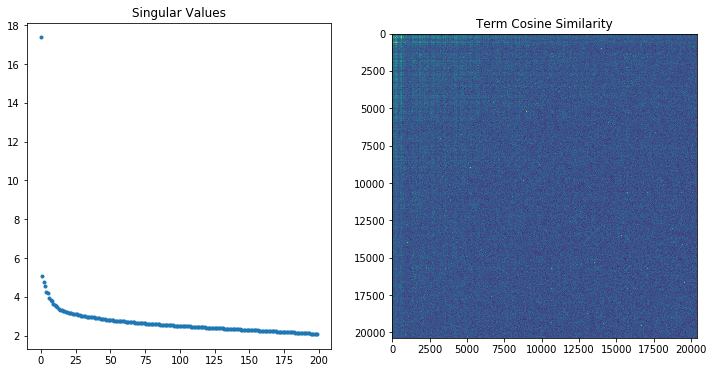

In [123]:
# scipy SVD to compute term similarity
num_comp = 200

# get dense tfidf matrix to do SVD in scipy to compare word similarities
mat_tfidf = gs.matutils.corpus2dense(corpus_tfidf, len(terms_dict.dfs))
TSVD = decomposition.TruncatedSVD(n_components=num_comp)
TSVD.fit_transform(mat_tfidf.T)
U = TSVD.components_
TSVD.fit_transform(mat_tfidf)
V = TSVD.components_
S = np.diag(TSVD.singular_values_)

# get transformed word vectors
# QUESTION: why multiply by the singular values here?
# U is an unitary matrix (N_t x k), therefore >np.matmul(U,U.T) == metrics.pairwise.cosine_similarity(U)
#    columns of U are the bases of the projected space, and multiplying by S gives the weighted length?
#
# X_star is the low dimensional approximation of X, so X_star*X_star.T gives the covariance matrix of 
#    the low-d term vectors. U is the "term" basis matrix in the low-D projection space, U*S gives the actual 
#    projected length of each term vector in the low-D space.
# S stretches the low-D basis (k space) differently for each k, i.e. it emphasises some dimensions
# conceptually, if one dimension is way more important than the others, than scaling it more will
# emphasize differences/similiarities along that axis only
t_star = np.matmul(S,U).T

# word similarity from raw tfidf matrix
term_sim_raw = metrics.pairwise.cosine_similarity(mat_tfidf) 
# word similarity from LSA transformed matrix
term_sim_LSA = metrics.pairwise.cosine_similarity(t_star)
print('Term Similarity Matrix: (%i, %i)'%term_sim_LSA.shape)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(TSVD.singular_values_, '.')
plt.title('Singular Values')
plt.subplot(1,2,2)
plt.imshow(term_sim_LSA - sp.eye(term_sim_LSA.shape[0]))
plt.title('Term Cosine Similarity')

In [130]:
terms_similar_to(term_sim_LSA, terms_dict, 'learning', 50)

Freq. | Similarity: Term
------------------------
0.257 | 1.000: learning
0.258 | 1.000: earning
0.300 | 0.994: learn
0.302 | 0.994: earn
0.057 | 0.721: learned
0.058 | 0.719: earned
0.062 | 0.707: learner
0.052 | 0.686: learners
0.104 | 0.658: novel
0.926 | 0.620: ea
0.565 | 0.608: ov
0.970 | 0.606: le
0.914 | 0.606: ne
0.852 | 0.600: tr
0.877 | 0.597: ex
0.900 | 0.597: x
0.990 | 0.596: ing
0.668 | 0.596: ab
0.754 | 0.596: ia
0.994 | 0.595: ng
0.895 | 0.595: ac
0.930 | 0.595: ta
0.942 | 0.595: ts
0.868 | 0.594: mo
0.880 | 0.594: im
0.961 | 0.594: ro
0.808 | 0.594: mp
0.924 | 0.593: ca
0.998 | 0.593: b
0.992 | 0.593: st
0.977 | 0.593: ha
0.653 | 0.593: wo
1.000 | 0.593: th
1.000 | 0.593: p
0.997 | 0.593: nt
1.000 | 0.593: u
1.000 | 0.593: g
0.888 | 0.593: la
0.999 | 0.592: er
1.000 | 0.592: f
0.999 | 0.592: en
0.998 | 0.592: es
0.998 | 0.592: v
0.999 | 0.592: w
0.998 | 0.592: te
0.996 | 0.592: nd
0.967 | 0.591: de
0.749 | 0.591: wi
0.995 | 0.591: al
0.893 | 0.590: hat


In [17]:
LSA_terms = [t for t in terms_dict.id2token.values()]
most_similar_subset(LSA_terms, LSA_terms, t_star, ['working memory'], topn=20)

[('working memory', 0.9999999999999994),
 ('spatial working memory', 0.6135711618218438),
 ('phonological loop', 0.5557219920660053),
 ('visual working memory', 0.5363495698499948),
 ('phonological working memory', 0.49529758917529015),
 ('central executive', 0.49202992446144556),
 ('interference control', 0.4808408819674233),
 ('gestalt grouping', 0.4764807736098769),
 ('memory', 0.4419814054631442),
 ('interference resolution', 0.4252386282272916),
 ('working memory updating', 0.38984414545734536),
 ('cognitive training', 0.37816436216590055),
 ('response selection', 0.37097945844779523),
 ('change blindness', 0.3406395493766734),
 ('semantic working memory', 0.3373797349706995),
 ('color perception', 0.31109684946355154),
 ('phonological awareness', 0.2834325864733303),
 ('attentional state', 0.27545342957797314),
 ('contingency learning', 0.26197228092559016),
 ('goal management', 0.2608836232325308)]

### Clustering

[28, 17, 16, 11, 22, 361, 15, 11, 8, 11, 10, 10]


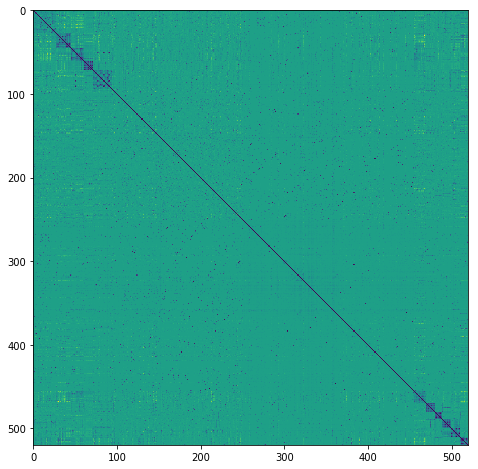

In [18]:
# because transformed word vectors can be negative, apply heat kernel:
#      similarity = np.exp(-beta * distance / distance.std())
beta=0.001
n_clusters = 12
term_dist_LSA = 1.-term_sim_LSA
clu = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')

clu.fit(np.exp(-(beta/term_dist_LSA.std())*term_dist_LSA))
clu_label = clu.labels_

#clu_label = clu.fit(np.exp(-beta * (1.-term_sim_LSA)/(1.-term_sim_LSA).std()))
clu_inds = np.argsort(clu_label)
plt.figure(figsize=(8,8))
plt.imshow(term_dist_LSA[clu_inds,:][:,clu_inds])
print([len(np.where(clu_label==c)[0]) for c in range(n_clusters)])
clustered_terms = [[terms_dict.id2token[i] for i in np.where(clu_label==query_clu)[0]] for query_clu in range(n_clusters)]

In [19]:
pd.DataFrame([t[:10] for t in clustered_terms], index=['Clu%i'%i for i in range(n_clusters)])

,0,1,2,3,4,5,6,7,8,9
Clu0,attention,prejudice,perceptual skill,attentional resources,rehearsal,focused attention,attentional blink,inattention,inattentional blindness,involuntary attention
Clu1,intertemporal choice,curiosity,deliberation,analogical inference,analogical transfer,conceptual priming,relational learning,stereotypes,fluid intelligence,rule learning
Clu2,centration,declarative memory,memory decay,dyslexia,implicit memory,feature-based attention,phonological awareness,phonological processing,serial learning,deductive reasoning
Clu3,explicit memory,consolidation,memory consolidation,sleep,proactive interference,retroactive interference,reconsolidation,dream,delusion,fatigue
Clu4,perception,face perception,interoception,object recognition,hallucination,grapheme,object perception,visual object recognition,color perception,subconscious
Clu5,concept,focus,goal,learning,search,causal inference,inference,action,activation,decision
Clu6,assimilation,syntactic processing,lexical access,pronunciation,lexical retrieval,context dependent,difference threshold,cognitive effort,word pronunciation,lexical processing
Clu7,conflict detection,inhibition,inhibition of return,response conflict,excitation,response inhibition,interrogative,feature integration,response execution,negative priming
Clu8,imagery,mental imagery,text processing,visual imagery,auditory imagery,gestalt,motion aftereffect,proprioception,None,None
Clu9,detection,response bias,abductive reasoning,visual angle,motion detection,global precedence,oddball detection,error detection,object detection,object-based attention


# word2vec
gensim word2vec takes list of sentences as input.

Questions:
- how best to combine phrases?
- should words be stemmed?
https://machinelearningmastery.com/clean-text-machine-learning-python/

In [31]:
# combine title & abstract of each document and put into list
exclude = set(string.punctuation) - {'-'} # don't discard dashes
sentence_list = []
for t in range(len(df_cs)):
    sentence_list.append(df_cs['Title'][t])
    # check if the abstract is empty
    if type(df_cs['Abstract'][t]) is str:
        sentence_list = sentence_list + df_cs['Abstract'][t].split('.')

# get rid of blanks, punctuations, and convert sentences into lists of words
sentence_list = [''.join(ch for ch in s if ch not in exclude).lower().split() for s in sentence_list if s is not '']

In [32]:
# loop over again to combine words that are phrases in the cognitive terms
sentence_list, terms_merged = terms_to_phrases(sentence_list, terms['Terms'], merge_char='-')

abductive-reasoning
abstract-analogy
abstract-knowledge
acoustic-coding
acoustic-encoding
acoustic-phonetic-processing
acoustic-processing
action-initiation
action-perception
activation-level
active-maintenance
active-recall
active-retrieval
adaptive-control
affect-perception
affect-recognition
altruistic-motivation
amodal-representation
analog-representation
analogical-encoding
analogical-inference
analogical-problem-solving
analogical-reasoning
analogical-transfer
animacy-decision
animacy-perception
antisocial-personality
apparent-motion
appetitive-motivation
arithmetic-processing
arousal-(emotion)
arousal-(physical)
articulatory-loop
articulatory-planning
articulatory-rehearsal
association-learning
associative-priming
attended-channel
attended-stimulus
attention-capacity
attention-shift
attention-shifting
attention-span
attentional-bias
attentional-blink
attentional-effort
attentional-focusing
attentional-resources
attentional-state
audiovisual-perception
auditory-arithmetic-process

proper-noun
prosodic-stress
prospective-memory
prospective-planning
psychological-refractory-period
punishment-processing
quantitative-skill
reception-of-facial-communication
reception-of-non-facial-communication
rehearsal-loop
reinforcement-learning
relational-comparison
relational-learning
remote-memory
repetition-priming
repressed-memory
resistance-to-distractor-inference
resource-limit
resource-sharing
response-bias
response-conflict
response-execution
response-inhibition
response-priming
response-selection
restricted-behavior
retrieval-cue
retroactive-interference
reward-anticipation
reward-learning
reward-processing
reward-valuation
right-finger-response-execution
right-hand-response-execution
right-toe-response-execution
risk-aversion
risk-aversion
risk-processing
risk-seeking
route-knowledge
rule-learning
saccadic-eye-movement
selective-attention
selective-control
self-control
self-evaluation
self-knowledge
self-monitoring
self-talk
semantic-categorization
semantic-category
sem

In [33]:
len(terms_merged)

823

In [34]:
# get gensim model
model = gs.models.Word2Vec(sentence_list, min_count=2, size=100, window=10, sg=1)
w2v_vocab = model.wv.index2word # get the vocab of word2vec representation

In [36]:
# print_similarity(model.wv.most_similar(positive=['learning', 'categorization'], topn=20))
# print_similarity(model.wv.most_similar(positive=['learning'], negative=['categorization'], topn=20))

print_similarity(model.wv.most_similar(positive=['dopamine'], negative=['learning'], topn=20))
print_similarity(model.wv.most_similar(positive=['dopamine'], negative=['brain'], topn=20))

----------------
Cosine Similiarty
---------------
0.6002: anterior
0.6002: lobe
0.5833: cingulate
0.5773: dorsal
0.5764: premotor
0.5763: lateral
0.5656: prefrontal
0.5598: medial
0.5579: sulcus
0.5515: bilateral
0.5510: gyrus
0.5496: sts
0.5495: parietal
0.5484: dorsolateral
0.5464: excitatory
0.5435: intraparietal
0.5426: insula
0.5421: specialization
0.5375: dlpfc
0.5360: pezzulo
----------------
Cosine Similiarty
---------------
0.5011: promotes
0.4958: exclusivity
0.4928: reconstructive
0.4899: replacement
0.4888: multivariable
0.4876: interdependence
0.4871: redundancy
0.4859: combinatorics
0.4840: cumulative
0.4835: impose
0.4829: exerts
0.4826: contrastive
0.4822: assignment
0.4820: luring
0.4819: explicit-knowledge
0.4815: bootstrapping
0.4806: optimizing
0.4782: favors
0.4773: inclusion
0.4758: visual-recognition


### Search for similarity 
###### In whole dictionary and cognitive terms-only.
below includes a custom most_similar function that restricts the search in a provided dictionary, in this case, the subset of cognitive terms

note that the custom function can in theory be applied to LSA word vectors as well

In [37]:
topn=10
positive = ['learning']
negative = []
negative = ['categorization']

print('\n--- Search in whole corpus: ---')
#print_similarity(model.wv.most_similar(positive=positive, negative=negative, topn=topn))
pd.DataFrame(model.wv.most_similar(positive=positive, negative=negative, topn=topn))

# print('\n--- Search only the cognitive terms: ---')
# print_similarity(most_similar_subset(model.wv.index2word,terms['Terms'],model.wv.vectors,positive,negative,topn))


--- Search in whole corpus: ---


,0,1
0,students,0.239675
1,learners,0.231441
2,learn,0.218886
3,school,0.215757
4,teaching,0.211989
5,achievement,0.211823
6,feedback,0.211125
7,program,0.208106
8,intervention,0.207478
9,student,0.200324


In [38]:
topn=10
positive = ['representation', 'memory']
negative = []
print_similarity(most_similar_subset(model.wv.index2word,terms['Terms'],model.wv.vectors,positive,negative,topn))

positive = ['representation']
negative = ['memory']
print_similarity(most_similar_subset(model.wv.index2word,terms['Terms'],model.wv.vectors,positive,negative,topn))

----------------
Cosine Similiarty
---------------
0.8826: memory
0.7501: maintenance
0.7148: retrieval
0.7127: consolidation
0.7059: forgetting
0.6918: reconsolidation
0.6826: rehearsal
0.6753: interoception
0.6647: habit
0.6639: prototype
----------------
Cosine Similiarty
---------------
0.2527: concept
0.1754: meaning
0.1325: schema
0.1318: logic
0.1240: irony
0.1172: lexicon
0.1144: intentionality
0.1058: goal
0.1016: syntax
0.0994: humor


In [39]:
# prediction based on context
model.predict_output_word(['cognitive','neuroscience','is'],topn=20)

[('science', 0.0015744863),
 ('sciences', 0.0010316365),
 ('neuroscience', 0.0009775447),
 ('linguistics', 0.0008342717),
 ('psychology', 0.0008149031),
 ('cognitive', 0.0007487715),
 ('scientists', 0.0007164964),
 ('philosophy', 0.0006763069),
 ('symposium', 0.0006325993),
 ('architecture', 0.00062407076),
 ('cognition', 0.00057237444),
 ('disciplines', 0.0005495311),
 ('areas', 0.0005156055),
 ('social', 0.0005107495),
 ('research', 0.00050460204),
 ('growing', 0.0004725565),
 ('including', 0.00046136463),
 ('field', 0.00045781877),
 ('education', 0.00045271803),
 ('system', 0.00044740128)]

Term Similarity Matrix: (17150, 17150)


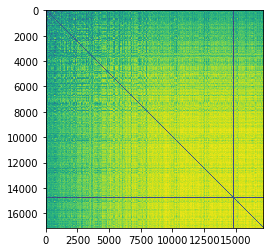

In [40]:
term_sim_w2v = metrics.pairwise.cosine_similarity(model.wv.vectors)
print('Term Similarity Matrix: (%i, %i)'%term_sim_w2v.shape)
plt.imshow(term_sim_w2v - sp.eye(term_sim_w2v.shape[0]))

###### can also run word2vec with just corpus words, but that's probably too little data 
I think this basically just grabs co-occurrence, but it seems that the vector arithmetics still "work"

In [41]:
corpus_terms # renamed as docs_as_terms
# get gensim model
model_reduced = gs.models.Word2Vec(corpus_terms, min_count=1, size=200, window=5, sg=1)
model_reduced.wv.most_similar(positive=['learning'], negative=['categorization'], topn=20)

[('domain specificity', 0.052657343447208405),
 ('creative cognition', 0.03384580835700035),
 ('cognitive dissonance', 0.03358886018395424),
 ('perceptual binding', 0.02431131899356842),
 ('object-based attention', 0.021590828895568848),
 ('word generation', 0.012599781155586243),
 ('language acquisition', 0.008719602599740028),
 ('oddball detection', 0.008435919880867004),
 ('language', 0.008409757167100906),
 ('interoception', 0.0030625611543655396),
 ('story comprehension', 0.0009637679904699326),
 ('word pronunciation', 0.0009134011343121529),
 ('visual orientation', 0.0006997324526309967),
 ('language production', 0.0004796832799911499),
 ('skepticism', 0.0003247801214456558),
 ('language processing', -0.0005148239433765411),
 ('conflict adaptation effect', -0.0005677049048244953),
 ('lexicon', -0.0006438568234443665),
 ('animacy perception', -0.0008073663339018822),
 ('saccadic eye movement', -0.0011958228424191475)]

# load pretrained GoogleNews word vectors

In [25]:
# this will take some time and memory
gnews_data_file = '/Users/rdgao/Documents/data/IdentityCrisis/GoogleNews-vectors-negative300.bin.gz'
model_gnews = gs.models.KeyedVectors.load_word2vec_format(gnews_data_file, binary=True)

In [26]:
# precompute subset indices
subset_inds = np.sort([model_gnews.index2word.index(t) for t in terms['Terms'] if t in model_gnews.index2word]) 

In [27]:
# full search has too many garbage words, need to prune to a smaller subset
# maybe only the cognitive terms, or even the whole vocab from cogsci
topn=10
positive = ['representation', 'memory']
#positive = ['memory','categorization']
negative = []
#negative = ['categorization']
# print('\n--- Search in whole corpus: ---')
# print_similarity(model_gnews.most_similar(positive=positive, negative=negative, topn=topn))

print('\n--- Search only the cognitive terms: ---')
print_similarity(most_similar_subset(model_gnews.index2word,subset_inds,model_gnews.vectors,positive,negative,topn))

positive = ['representation']
negative = ['memory']
print_similarity(most_similar_subset(model_gnews.index2word,subset_inds,model_gnews.vectors,positive,negative,topn))


--- Search only the cognitive terms: ---
Using precomputed subset indices...
----------------
Cosine Similiarty
---------------
0.7448: memory
0.3708: recognition
0.3191: consciousness
0.3128: perception
0.2843: communication
0.2830: logic
0.2817: encoding
0.2799: knowledge
0.2717: imagery
0.2717: reconsolidation
Using precomputed subset indices...
----------------
Cosine Similiarty
---------------
0.2130: action
0.1928: discrimination
0.1844: articulation
0.1688: deliberation
0.1540: prejudice
0.1452: coordination
0.1329: resource
0.1272: localization
0.1232: recognition
0.1188: expertise


# t-SNE on CogSci word2vec vectors

In [28]:
from sklearn.manifold import TSNE

In [29]:
# compute subset indices for cognitive terms
subset_inds_cs = np.sort([model.wv.index2word.index(t) for t in terms_merged if t in model.wv.index2word]) 
tsne_w2v = TSNE(n_components=2)
wv_2d = tsne_w2v.fit_transform(model.wv.vectors[subset_inds_cs,:])

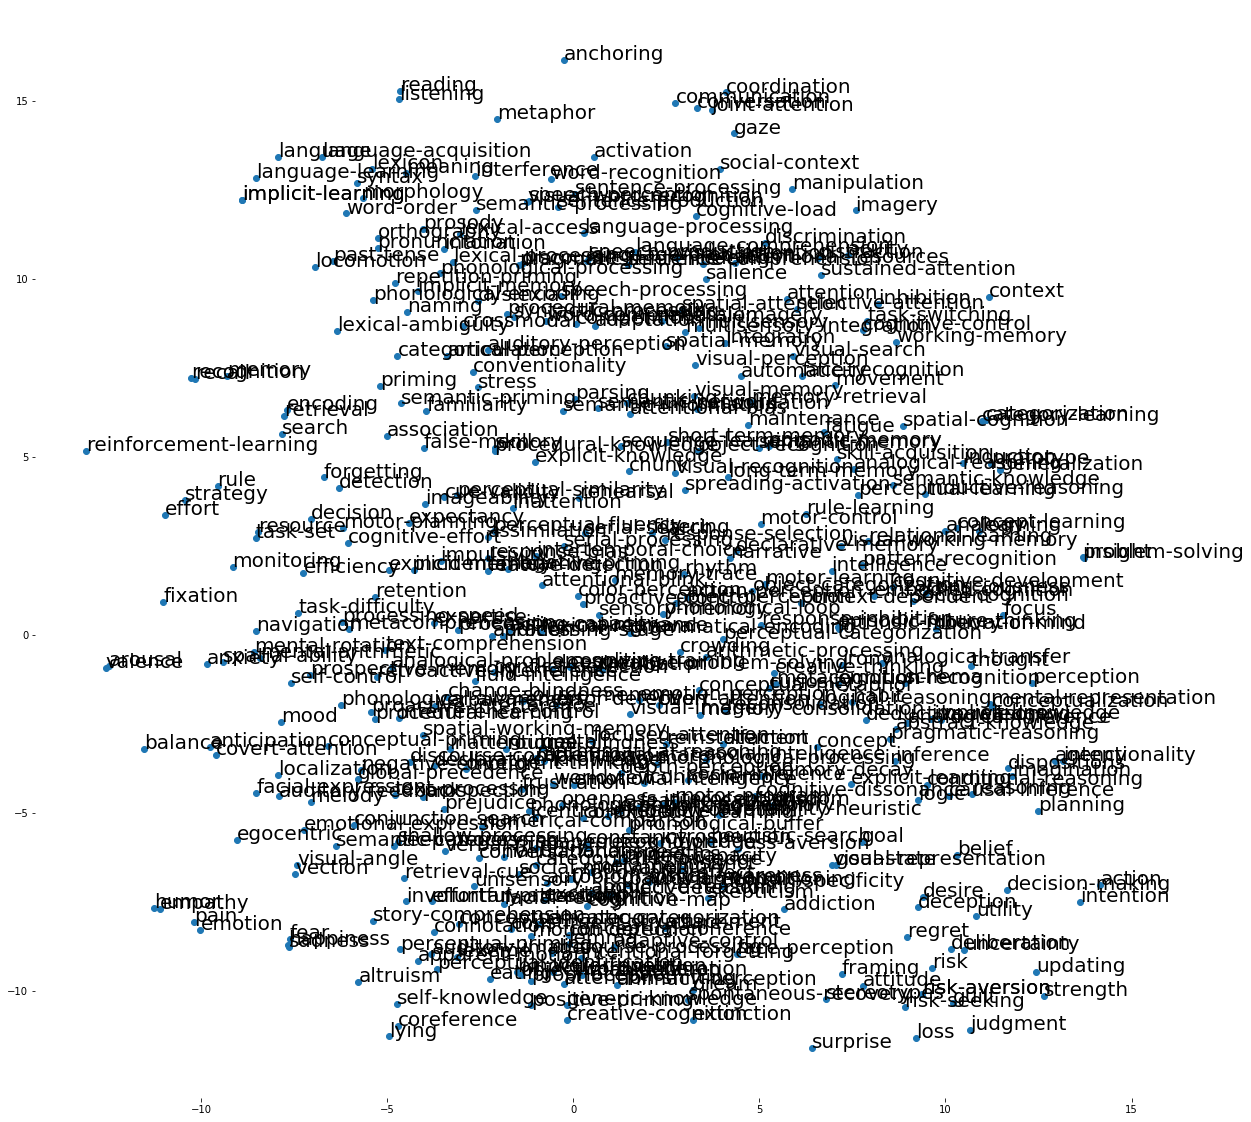

In [30]:
plt.figure(figsize=(20,20))
plt.scatter(wv_2d[:,0],wv_2d[:,1])
for i,w in enumerate(wv_2d):
    plt.annotate(model.wv.index2word[subset_inds_cs[i]], (w), fontsize=20, rotation=0)
    
plt.box('off')
#plt.xlim([2,4])